<center>
<h1>Time Series Analysis</h1>
</center>

In [1]:
!pip install statsmodels==0.12.0 scipy==1.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.4/28.4 MB 39.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.13.5
    Uninstalling statsmodels-0.13.5:
      Successfully uninstalled statsmodels-0.13.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.10.1 requires statsmodels>=0.13.2, but you have statsmodels 0.12.0 which is incompatible.


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
plt.rcParams["figure.figsize"] = (12,4)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 14

In [4]:
dataset = pd.read_csv('https://raw.githubusercontent.com/deba-iitbh/datasets/main/AirPassengers.csv')
dataset['Month'] = pd.to_datetime(dataset['Month'])
indexedDataset = dataset.set_index('Month')

## Exploring the Dataset

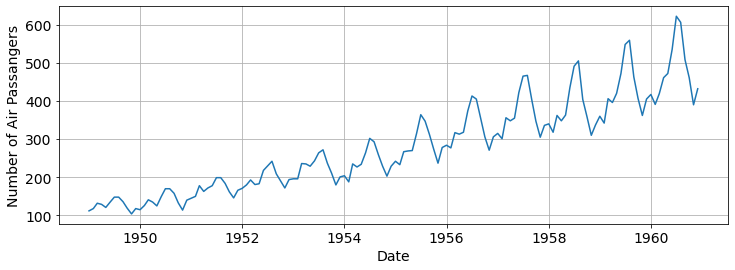

In [5]:
## plot graph
plt.xlabel("Date")
plt.ylabel("Number of Air Passangers")
plt.plot(indexedDataset)

In [6]:
# Determining the rolling stattistics
rollmean = indexedDataset.rolling(window = 12).mean()
rollstd = indexedDataset.rolling(window = 12).std()
print(rollmean, rollstd)

            #Passengers
Month                  
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
...                 ...
1960-08-01   463.333333
1960-09-01   467.083333
1960-10-01   471.583333
1960-11-01   473.916667
1960-12-01   476.166667

[144 rows x 1 columns]             #Passengers
Month                  
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
...                 ...
1960-08-01    83.630500
1960-09-01    84.617276
1960-10-01    82.541954
1960-11-01    79.502382
1960-12-01    77.737125

[144 rows x 1 columns]


In [7]:
indexedDataset.head(20)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


## Checking Stationarity with rolling mean and standard Deviation

In [8]:
rollmean.head(20)

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
1949-06-01,NaN
1949-07-01,NaN
1949-08-01,NaN
1949-09-01,NaN


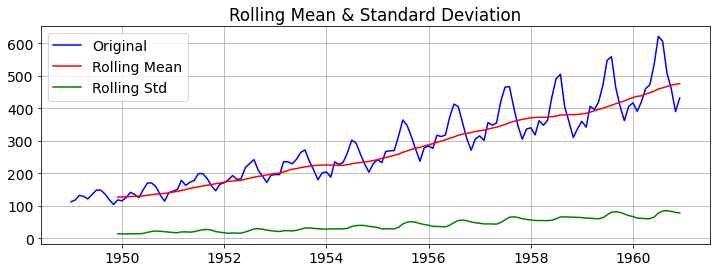

In [9]:
# Plot rolling statistics
orig = plt.plot(indexedDataset, color ='blue', label = 'Original')
mean = plt.plot(rollmean, color ='red', label = 'Rolling Mean')
std = plt.plot(rollstd, color ='green', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block = False)

## Checking Stationarity with Augmented Dickey Fuller Statistical Test

In [10]:
from statsmodels.tsa.stattools import adfuller

# Perform Dickey-Fuller Test
print("Results of Diceky-Fuller Test:")
dftest = adfuller(indexedDataset['#Passengers'], autolag = 'AIC')
dfoutput = pd.Series(dftest[:4], index= ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])

for key, value in dftest[4].items():
  dfoutput[f'Critical Value ({key})'] = value

print(dfoutput)

Results of Diceky-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


## Wrapping Visual and Statistical tools in a single function

In [11]:
def test_stationarity(timeseries):
  # Determining the rolling stattistics
  movingAverage = timeseries.rolling(window = 12).mean()
  movingSTD = timeseries.rolling(window = 12).std()

  # Plot rolling statistics
  orig = plt.plot(timeseries, color ='blue', label = 'Original')
  mean = plt.plot(movingAverage, color ='red', label = 'Rolling Mean')
  std = plt.plot(movingSTD, color ='green', label = 'Rolling Std')
  plt.legend(loc = 'best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show(block = False)

  # Perform Dickey-Fuller Test
  print("Results of Diceky-Fuller Test:")
  dftest = adfuller(timeseries['#Passengers'], autolag = 'AIC')
  dfoutput = pd.Series(dftest[:4], index= ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])

  for key, value in dftest[4].items():
    dfoutput[f'Critical Value ({key})'] = value

  print(dfoutput)

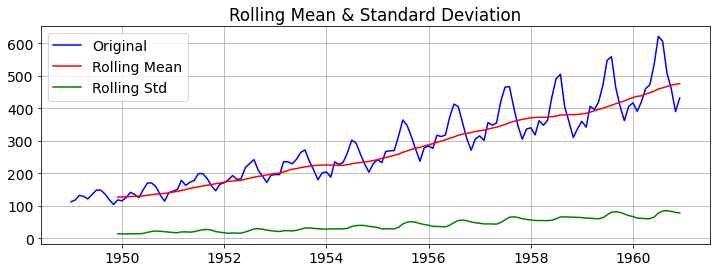

Results of Diceky-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [12]:
test_stationarity(indexedDataset)

## Converting Non-Stationary data to Stationary dataset
- Log
- Subtracting Simple rolling Average
- Subtracting Exponential rolling Average
- Subtracting previous value(Most Popular) with shift()
- Seasonal decomposition
- Combination of the above

### 1. Log

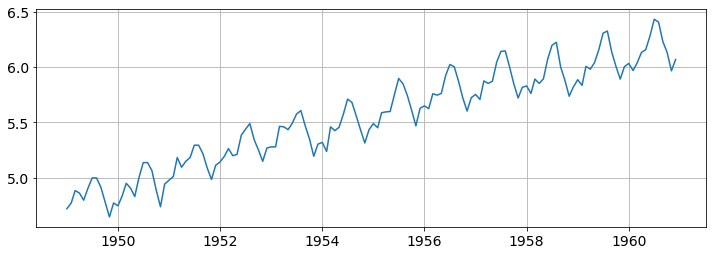

In [13]:
#Estimating trend
indexedDataset_logscale = np.log(indexedDataset)
plt.plot(indexedDataset_logscale)
plt.show()

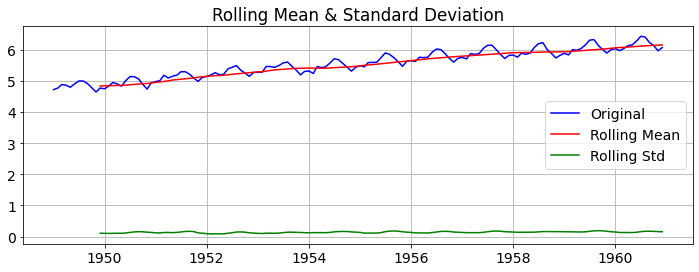

Results of Diceky-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [14]:
test_stationarity(indexedDataset_logscale)

### 2. Differencing Simple Moving Average

In [15]:
movingAverage = indexedDataset_logscale.rolling(window = 12).mean()
datasetLogScalMinusMovingAverage = indexedDataset_logscale - movingAverage
display(datasetLogScalMinusMovingAverage.head(12))

# Remove nan values
datasetLogScalMinusMovingAverage.dropna(inplace= True)
datasetLogScalMinusMovingAverage.head(10)

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
1949-06-01,NaN
1949-07-01,NaN
1949-08-01,NaN
1949-09-01,NaN


,#Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142
1950-05-01,-0.027529
1950-06-01,0.139881
1950-07-01,0.260184
1950-08-01,0.248635


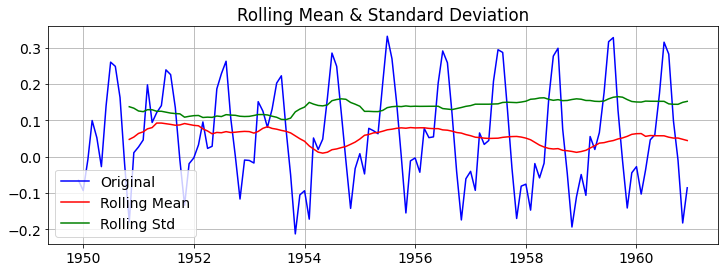

Results of Diceky-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [16]:
test_stationarity(datasetLogScalMinusMovingAverage)

### 3. Differencing Exponential Moving Average

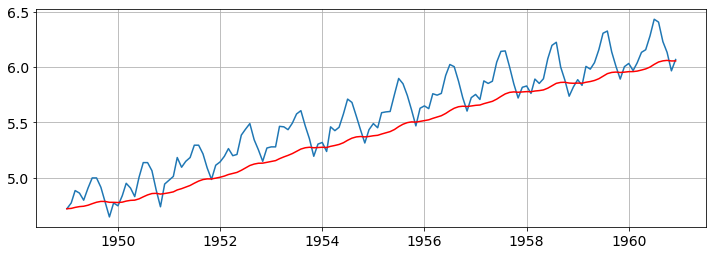

In [17]:
exponentialDecayWeightedAverage = indexedDataset_logscale.ewm(halflife = 12, min_periods = 0, adjust = 0).mean()
plt.plot(indexedDataset_logscale)
plt.plot(exponentialDecayWeightedAverage, color = 'red')
plt.show()

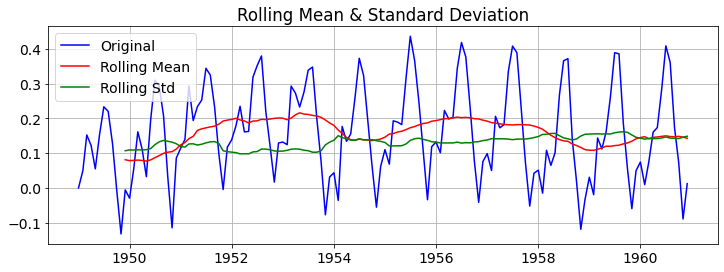

Results of Diceky-Fuller Test:
Test Statistic                  -2.891928
p-value                          0.046295
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [18]:
datasetLogScaleMovingExponentialDecayAverage = indexedDataset_logscale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMovingExponentialDecayAverage)

### 4. Differencing Previous Value

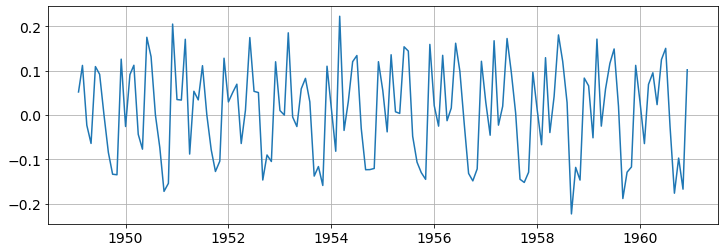

In [19]:
datasetLogDiffShifting = indexedDataset_logscale - indexedDataset_logscale.shift()
plt.plot(datasetLogDiffShifting)
plt.show()

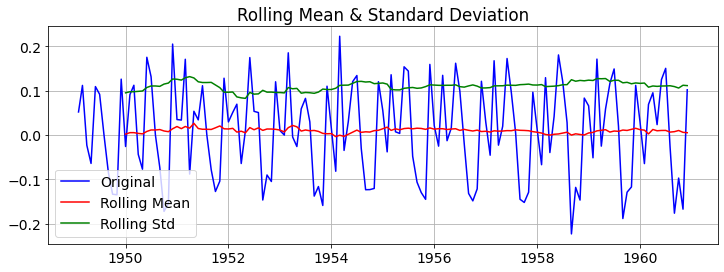

Results of Diceky-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [20]:
datasetLogDiffShifting.dropna(inplace = True)
test_stationarity(datasetLogDiffShifting)

### 5. Seasonal Decomposition

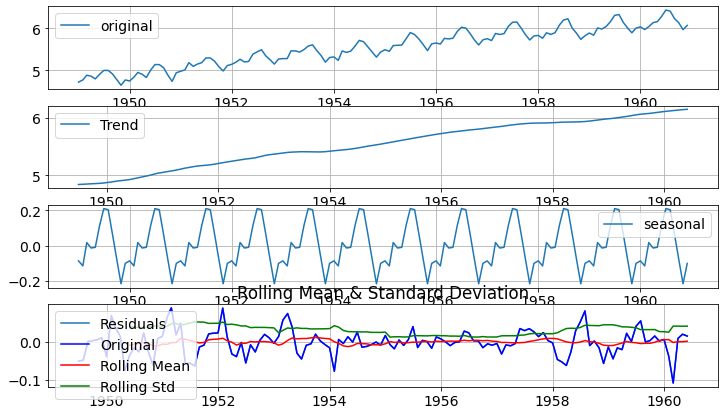

Results of Diceky-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(indexedDataset_logscale)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize = (12, 7))
plt.subplot(411)
plt.plot(indexedDataset_logscale, label = "original")
plt.legend()

plt.subplot(412)
plt.plot(trend, label = "Trend")
plt.legend()


plt.subplot(413)
plt.plot(seasonal, label = "seasonal")
plt.legend()


plt.subplot(414)
plt.plot(residual, label = "Residuals")
plt.legend()


decomposedLogData = residual
decomposedLogData.dropna(inplace = True)
test_stationarity(decomposedLogData.to_frame(name = "#Passengers"))

In [22]:
type(decomposedLogData)

pandas.core.series.Series

## ARMA modelling

### Auto Regressive Model

AR(1)
$$
P(today) = Mean + Coeff * P(yesterdat) + noise
$$
$$
P(t) = \mu + \gamma_1 * P(t-1) + \epsilon
$$
- If gamma_1 = 0 model is Mean plus noise

AR(2)
$$
P(t) = \mu + \gamma_1 * P(t-1) + \gamma_2 * P(t-2) \epsilon
$$

### Moving Average MA Model
MA(1) Model
$$
P(t) = \mu + \theta1 * \epsilon(t-1) + \epsilon(t)
$$

## ARMA Model
ARMA(1,1)
$$
P(t) = \mu + \gamma_1 * P(t-1) + \theta_1 * \epsilon(t-1) + \epsilon(t)
$$

ARMA(1,2)
$$
P(t) = \mu + \gamma_1 * P(t-1) + \theta_1 * \epsilon(t-1) + \theta_2 * \epsilon(t-2) + \epsilon(t)
$$

ARMA(2,1)
$$
P(t) = \mu + \gamma_1 * P(t-1) + \gamma_1 * P(t-2) + \theta_1 * \epsilon(t-1) + \epsilon(t)
$$

ARMA(2,2)
$$
P(t) = \mu + \gamma_1 * P(t-1) + \gamma_1 * P(t-2) + \theta_1 * \epsilon(t-1) + \theta_2 * \epsilon(t-2) + \epsilon(t)
$$

## Finding Lags of AR and MA models

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:662: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


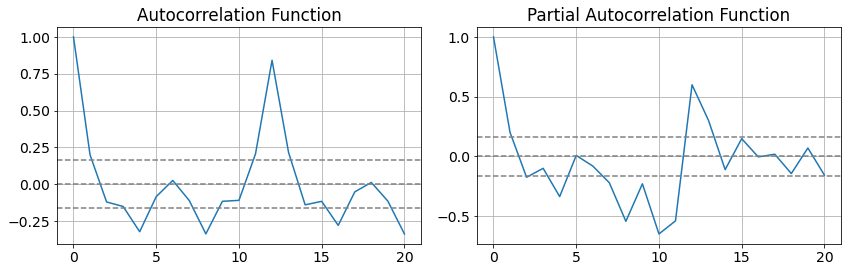

In [23]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle = '--', color="gray")
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle="--",color="gray")
plt.axhline (y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle="--", color= "gray")
plt.title("Autocorrelation Function")

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--', color="gray")
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle="--",color='gray')
plt.axhline (y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle="--",color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()

In [24]:
from statsmodels.tsa.stattools import arma_order_select_ic
arma_order_select_ic(datasetLogDiffShifting)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


{'bic':             0           1           2
 0 -225.639206 -228.618781 -228.527575
 1 -226.497365 -229.756336 -250.375467
 2 -225.753257 -255.336995 -269.503740
 3 -222.137562 -252.308070 -249.418687
 4 -232.957928 -253.670744 -253.229736, 'bic_min_order': (2, 2)}

## AR Model

Plotting AR model


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be us

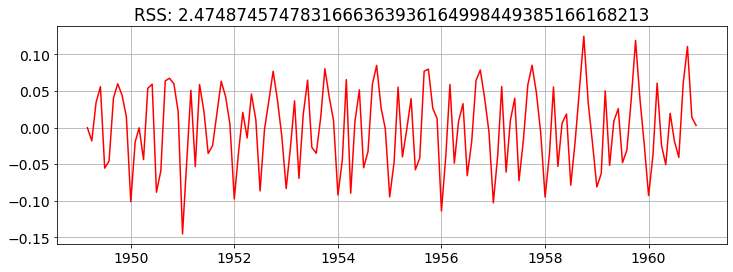

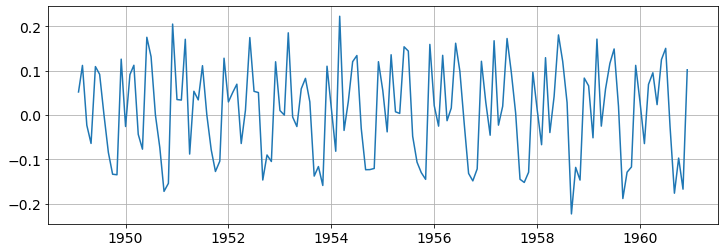

In [25]:
from statsmodels.tsa.arima_model import ARIMA

#AR MODEL
print("Plotting AR model")
model = ARIMA(datasetLogDiffShifting, order=(2, 1, 0))
results_AR = model.fit(disp=-1)
plt.plot(results_AR. fittedvalues, color="red")
title = ((results_AR.fittedvalues - datasetLogDiffShifting ["#Passengers"])**2).sum()
plt.title(f"RSS: {title:.44}")
plt.show()

plt.plot(datasetLogDiffShifting)

## MA Model

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be us

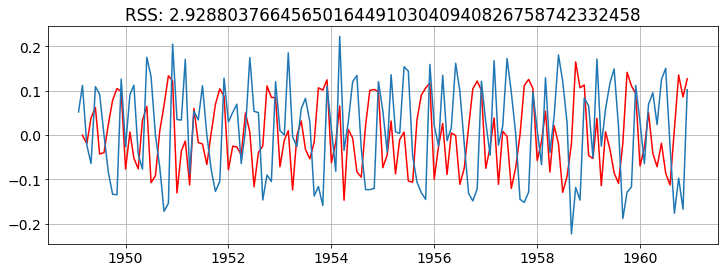

In [34]:
#MA MODEL
model = ARIMA (datasetLogDiffShifting, order=(0, 1, 2))
results_MA = model.fit(disp=-1)
plt.plot(results_MA.fittedvalues, color="red")
plt.plot(datasetLogDiffShifting)
title = ((results_MA.fittedvalues - datasetLogDiffShifting["#Passengers"])**2).sum()
plt.title(f"RSS: {title:.44}")
plt.show()

## ARIMA

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be us

Text(0.5, 1.0, 'RSS: 2.2619')

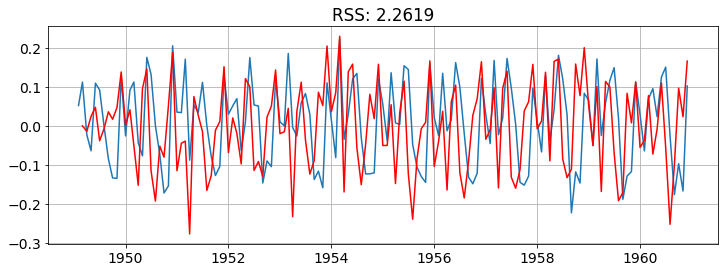

In [35]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA (datasetLogDiffShifting, order=(8, 1, 2))
results_ARIMA = model.fit()
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA. fittedvalues, color='red')
plt.title('RSS: %.4f'% ((results_ARIMA. fittedvalues-datasetLogDiffShifting["#Passengers"])**2).sum())

### Getting Predictions

In [28]:
predictions_ARIMA_diff = pd.Series (results_ARIMA. fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Month
1949-03-01   -0.000036
1949-04-01   -0.014147
1949-05-01    0.024155
1949-06-01    0.047527
1949-07-01   -0.038165
dtype: float64


Remember the predictions are in Log_differenceed values.We need to convert them to original form

In [29]:
#Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Month
1949-03-01   -0.000036
1949-04-01   -0.014183
1949-05-01    0.009972
1949-06-01    0.057499
1949-07-01    0.019334
dtype: float64


In [30]:
predictions_ARIMA_log = pd.Series(indexedDataset_logscale["#Passengers"].iloc[0], index=indexedDataset_logscale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.718499
1949-03-01    4.718463
1949-04-01    4.704316
1949-05-01    4.728471
dtype: float64

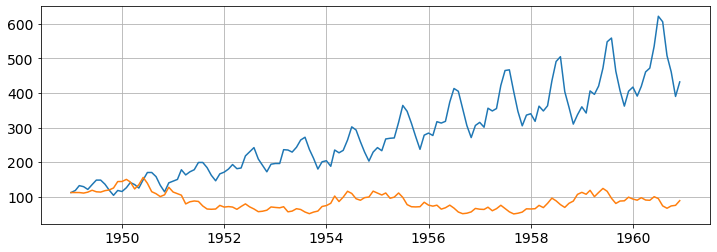

In [31]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(indexedDataset)
plt.plot(predictions_ARIMA)
plt.show()

In [32]:
results_ARIMA.forecast(steps = 120)

(array([ 0.08118823, -0.01090423,  0.01040425,  0.00663334,  0.10288552,
         0.12430766,  0.09100457, -0.04594297, -0.12990052, -0.08697164,
        -0.03991982,  0.02363333,  0.02437672, -0.01072023, -0.00568422,
         0.04979329,  0.10815105,  0.09973339,  0.0395251 , -0.04113031,
        -0.08135833, -0.05602863, -0.01670483, -0.00182661, -0.01267876,
        -0.01647051,  0.01151106,  0.06178192,  0.09369975,  0.07367779,
         0.01886753, -0.03002651, -0.04547939, -0.03189847, -0.01735974,
        -0.01927891, -0.02630093, -0.0141125 ,  0.02219963,  0.06109338,
         0.07439164,  0.05232808,  0.01335594, -0.01517438, -0.02260184,
        -0.0196775 , -0.02139268, -0.02878994, -0.02840584, -0.00840427,
         0.0254566 ,  0.05272903,  0.05675855,  0.03866745,  0.0141396 ,
        -0.00231276, -0.00919857, -0.0148143 , -0.02410483, -0.03116405,
        -0.02539724, -0.00382749,  0.02368375,  0.04190044,  0.04285003,
         0.03101428,  0.01683235,  0.00636303, -0.0

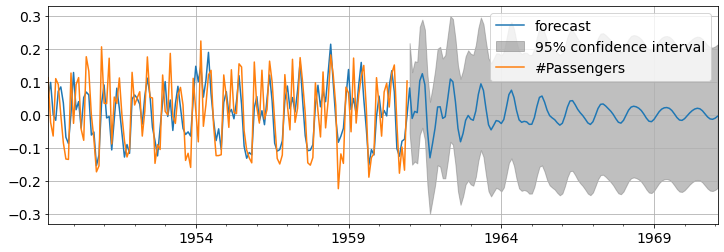

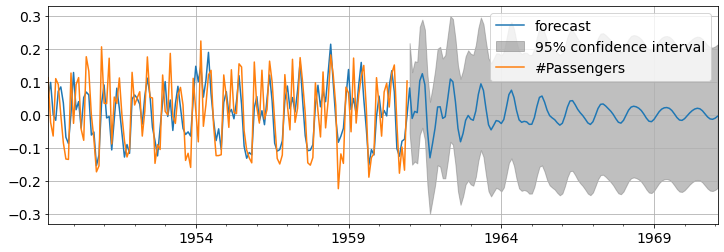

In [33]:
results_ARIMA.plot_predict(1,264)

## How to get better results
- Use Seasonal models
- Use Other Features
- Combining the above two tasks using SARIMAX model